In [1]:
from lib import *
import pandas as pd
import matplotlib.pyplot as plt

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

try:
    dfs = load_data_bq()
except Exception as e:
    dfs = load_data_db()
df_contratos = dfs["contract"].sort_values("created_at")
from datetime import timedelta
df_contratos['created_at'] = df_contratos['created_at'].dt.strftime("%Y-%m-%d")
df_contratos["created_at"] = pd.to_datetime(df_contratos["created_at"])
df_contratos["day_of_week"] = df_contratos["created_at"].dt.day_name()
df_contratos["month"] = df_contratos["created_at"].dt.month_name()
df_contratos["day_record_original"] = (df_contratos["created_at"] - df_contratos["created_at"].min()).dt.days
df_contratos["enum_month"] = df_contratos["created_at"].dt.month
df_contratos["enum_day_of_week"] = df_contratos["created_at"].dt.day_of_week

df_contratos_original = df_contratos.copy()
#1m23s

Erro ao executar a query contract_canceled.sql: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/formal-purpose-354320/jobs?prettyPrint=false: Access Denied: Project formal-purpose-354320: User does not have bigquery.jobs.create permission in project formal-purpose-354320.

Location: None
Job ID: fa15cbb0-a8fb-4e12-be10-909daef79a70

Erro geral: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/formal-purpose-354320/jobs?prettyPrint=false: Access Denied: Project formal-purpose-354320: User does not have bigquery.jobs.create permission in project formal-purpose-354320.

Location: None
Job ID: fa15cbb0-a8fb-4e12-be10-909daef79a70

Conexão estabelecida com sucesso!


In [2]:
date_range = pd.date_range(start=df_contratos["created_at"].min(), end=pd.to_datetime("2030-12-31"), freq='D')
df_dates = pd.DataFrame(date_range, columns=["date"])
df_dates["date"] = df_dates["date"].dt.strftime("%Y-%m-%d")
df_dates["date"] = pd.to_datetime(df_dates["date"])
df_dates["month"] = df_dates["date"].dt.month_name()
df_dates["day_of_week"] = df_dates["date"].dt.day_name()
df_dates["day_record_prediction"] = (df_dates["date"] - df_contratos["created_at"].min()).dt.days
df_dates["enum_month_prediction"] = df_dates["date"].dt.month
df_dates["enum_day_of_week_prediction"] = df_dates["date"].dt.day_of_week
df_dates = df_dates.merge(df_contratos, left_on=["month", "day_of_week"], right_on=["month", "day_of_week"], how="left")
df_dates["count_by_day"] = df_dates.groupby("date")["date"].transform("count")

#2.9s

2025-04-15 14:47:05.805018: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 14:47:05.820813: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 14:47:05.945626: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 14:47:06.056565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744739226.179753    7175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744739226.21

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 21908.8008 - mae: 95.6126 - val_loss: 17725.1680 - val_mae: 85.1655
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19275.3984 - mae: 88.1941 - val_loss: 17549.2285 - val_mae: 84.4113
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 19758.8926 - mae: 89.6053 - val_loss: 17463.1582 - val_mae: 84.1037
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 19295.2969 - mae: 87.5357 - val_loss: 17333.3711 - val_mae: 83.7120
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21141.4219 - mae: 93.9632 - val_loss: 17269.6270 - val_mae: 83.5967
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20129.8164 - mae: 90.3439 - val_loss: 17218.2031 - val_mae: 83.5318
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19145.1465 - mae: 89.2369 - val_loss: 17165.3398 - val_mae: 83.4734
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19675.7285 - mae: 89.9186 - val_loss

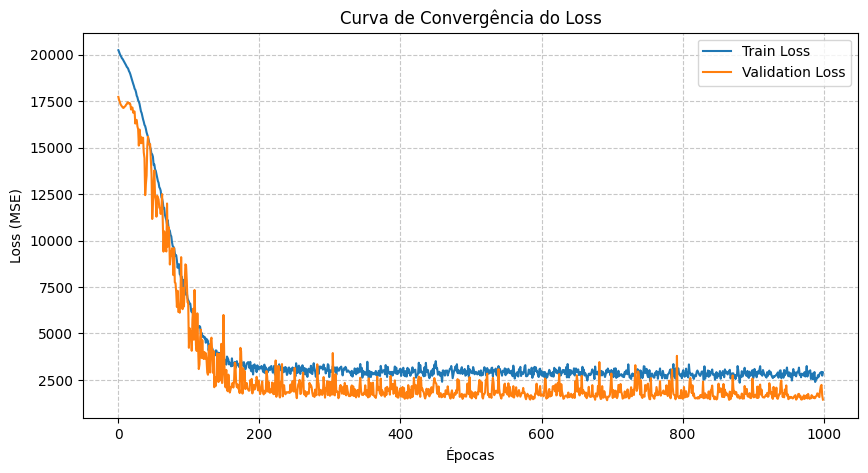

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Preparar os dados
df = df_contratos.copy()
df = df.groupby(["day_record_original", "enum_month", "enum_day_of_week"])["created_at"].count().reset_index()

# Selecionar features (entradas) e alvo (target)
features = ["day_record_original", "enum_month", "enum_day_of_week"]
X = df[features].values
y = df["created_at"].values

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras import layers, models

from tensorflow.keras import layers, models

# Modelo melhorado com Batch Normalization
model = models.Sequential()

# Camada de entrada com mais neurônios, BatchNormalization e ativação 'relu'
model.add(layers.Dense(32, input_shape=(X_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

# Camada oculta intermediária com BatchNormalization
model.add(layers.Dense(16))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))


# Camada oculta intermediária com BatchNormalization
model.add(layers.Dense(8))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

# Camada de saída com ativação linear (padrão para regressão)
model.add(layers.Dense(1, activation='relu'))

# Compilar o modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinar o modelo e salvar o histórico
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,
    batch_size=64,
    verbose=1
)

# Avaliar o modelo no conjunto de teste
loss, mae = model.evaluate(X_test, y_test, verbose=0)
# print(f"Test Loss (MSE): {loss:.4f} - Test MAE: {mae:.4f}")

# Fazer previsões
y_pred = model.predict(X_test)
# print("Previsões:", y_pred.flatten())

# Plotar a curva de convergência do loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de Convergência do Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


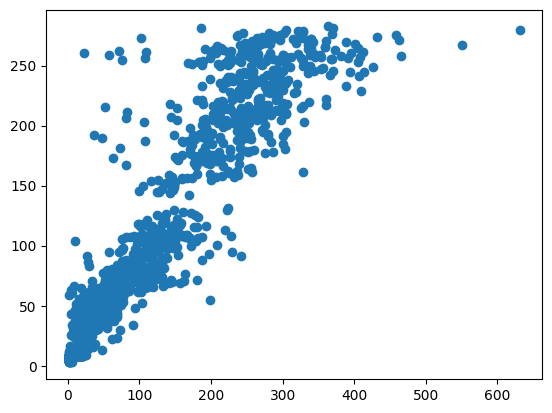

In [4]:
df = df_contratos.copy()
df = df.groupby(["day_record_original", "enum_month", "enum_day_of_week"])["created_at"].count().reset_index()
features = ["day_record_original", "enum_month", "enum_day_of_week"]
X = df[features].values
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
y_pred = model.predict(X)
df["pred"] = y_pred
plt.scatter(df["created_at"], df["pred"])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Text(0.5, 1.0, 'Ajuste do modelo aos dados reais')

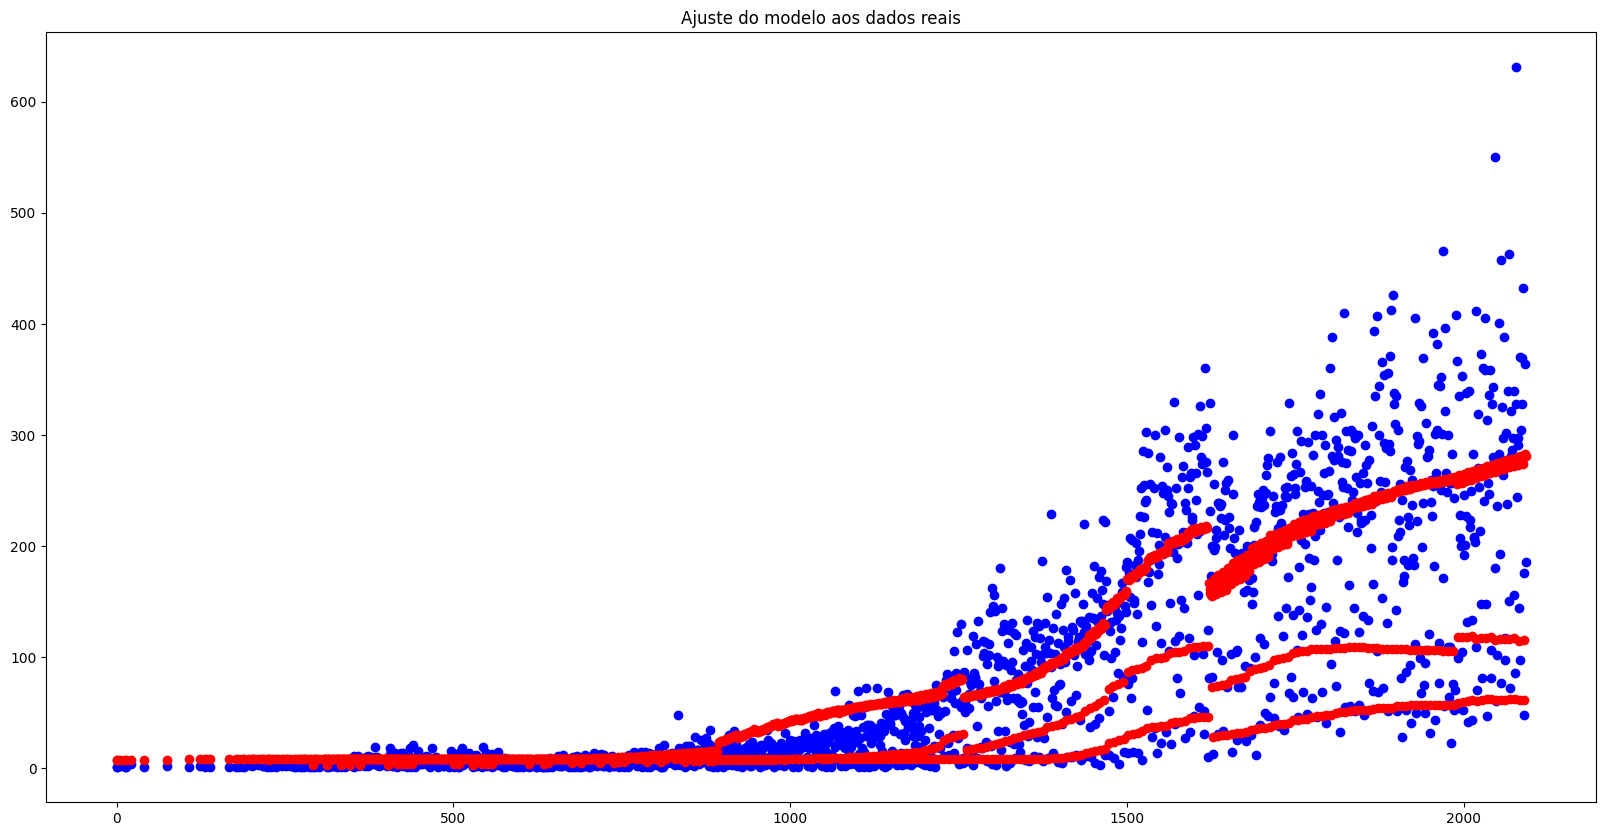

In [5]:
df = df_contratos.copy()
df = df.groupby(["day_record_original", "enum_month", "enum_day_of_week"])["created_at"].count().reset_index()
df["day_record_original"]  = df["day_record_original"]
features = ["day_record_original", "enum_month", "enum_day_of_week"]
X = df[features].values
y_pred = model.predict(X)
df["pred"] = y_pred


plt.figure(figsize=(20, 10))
plt.scatter(df["day_record_original"], df["created_at"], color="blue", label="Dados originais")
plt.scatter(df["day_record_original"], df["pred"], color="red", label="Modelo ajustado")
plt.title("Ajuste do modelo aos dados reais")


In [6]:
df = df_dates.copy()
df = df.sample(50000)
features = ["day_record_prediction", "enum_month", "enum_day_of_week"]
X = df[features].values
y_pred = model.predict(X)

df_dates = df.copy()
df_dates["num_of_contracts_predict"] = y_pred
df_dates["weight"] =  df_dates["count_by_day"] / 2153 * df_dates["num_of_contracts_predict"] 
df_dates["weight"] = df_dates["weight"] / df_dates.groupby("day_record_prediction")["num_of_contracts_predict"].transform("count")
#7,8s

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


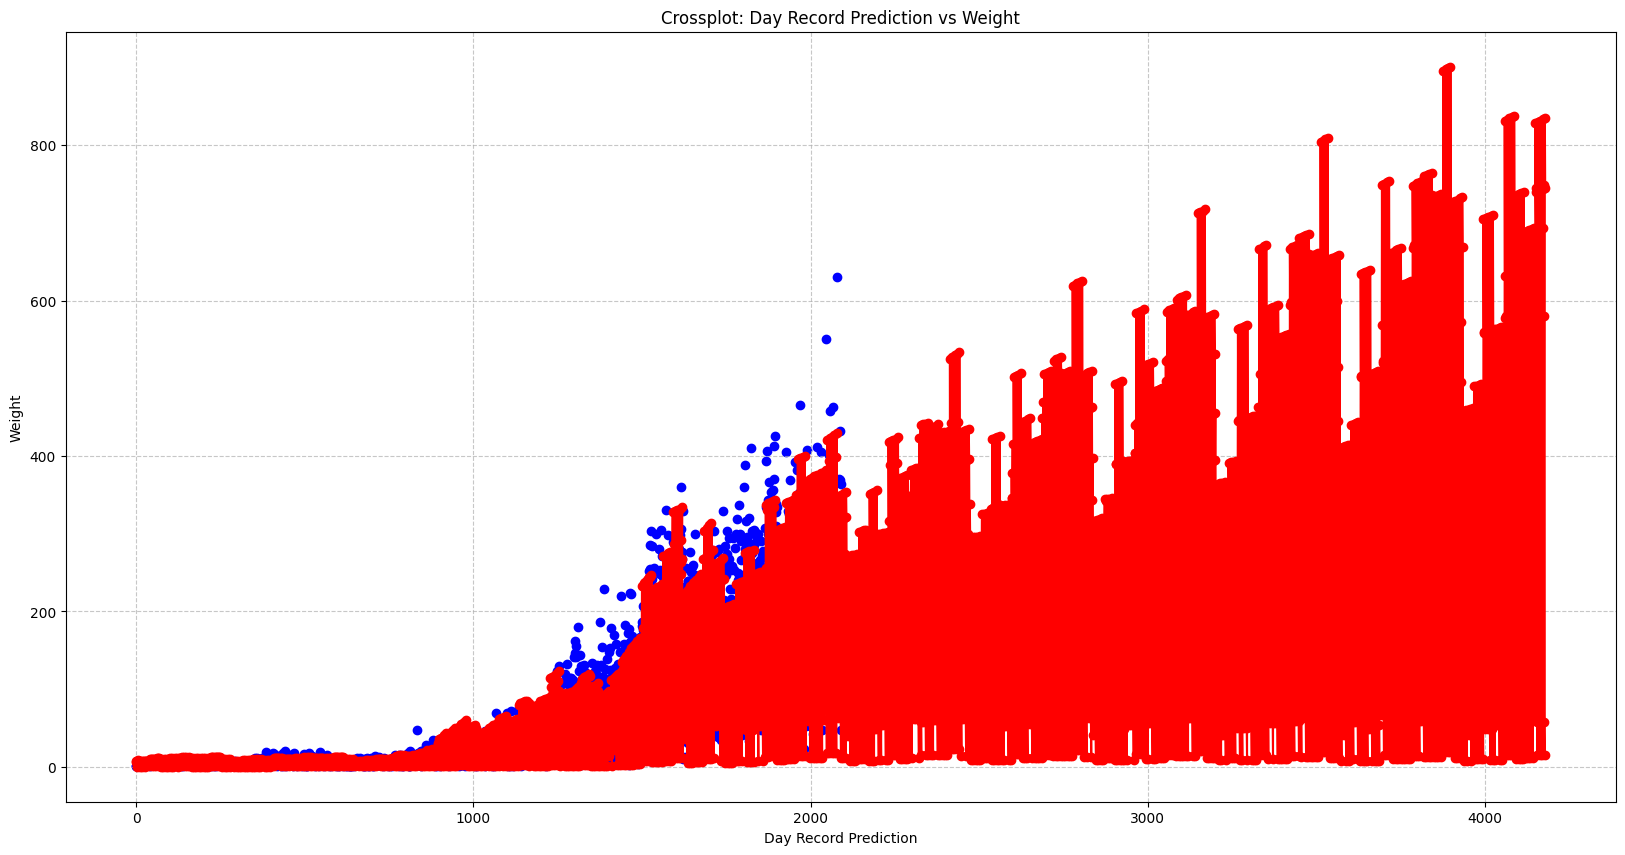

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


df = df_contratos.copy()
df = df.groupby("day_record_original")["created_at"].count().reset_index()

plt.figure(figsize=(20, 10))

plt.scatter(df["day_record_original"], df["created_at"], color="blue", marker="o")
plt.xlabel("Day Record Prediction")
plt.ylabel("Weight")
plt.title("Crossplot: Day Record Prediction vs Weight")
plt.grid(True, linestyle="--", alpha=0.7)


df = df_dates.copy()
df = df.groupby("day_record_prediction")["weight"].sum().reset_index()




plt.plot(df["day_record_prediction"], df["weight"], color="red", marker="o")
plt.xlabel("Day Record Prediction")
plt.ylabel("Weight")
plt.title("Crossplot: Day Record Prediction vs Weight")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [8]:
import pandas as pd
import csv

# Carrega o DataFrame da região e remove duplicatas para garantir unicidade
df_region = pd.read_csv("data/RELATORIO_DTB_BRASIL_DISTRITO.csv", delimiter=";")
df_region = df_region[["Nome_UF", "Nome_Município", "Nome_Mesorregião"]].drop_duplicates()

# Supondo que df_dates já exista, faça uma cópia para os resultados
df_resultados = df_dates.copy()

# Realiza o merge
df_resultados = df_resultados.merge(
    df_region, 
    how="left", 
    left_on=["state", "city"],
    right_on=["Nome_UF", "Nome_Município"]
)

# Remove as colunas desnecessárias e reorganiza as colunas
df_resultados = df_resultados.drop(["Nome_UF", "Nome_Município"], axis=1)

columns = [
    'date', 'month', 'day_of_week', 'city', 'state', 'freights_type',
    'contract_days','contract_value',  'vehicle', 'supply', 'Nome_Mesorregião', 'weight'
]
df_resultados = df_resultados[columns]

df_resultados.columns = [
    'date', 'month', 'day_of_week', 'city', 'state', 'freights_type',
    'contract_days', 'contract_value',  'vehicle', 'supply', 'region', 'weight'
]

df_resultados = df_resultados.sort_values("date")


In [9]:
display(df_resultados.head())
import json
df = df_resultados
exclude_cols = ['date', 'weight']
json_cols = [col for col in df.columns if col not in exclude_cols]
df['data_json'] = df[json_cols].apply(lambda row: json.dumps(row.to_dict()), axis=1)
df_resultados = df[['date', 'weight', 'data_json']]
display(df_resultados.head())


,date,month,day_of_week,city,state,freights_type,contract_days,contract_value,vehicle,supply,region,weight
43548,2019-07-24,July,Wednesday,Eusébio,Ceará,Coleta/Entrega,2.0,481,3/4,Grade baixa 3/4 e Toco,Metropolitana de Fortaleza,0.537253
34661,2019-07-24,July,Wednesday,Mogi das Cruzes,São Paulo,Diária,18.0,4860,Bi-Truck,Caçamba,Metropolitana de São Paulo,0.537253
10061,2019-07-24,July,Wednesday,Palhoça,Santa Catarina,Coleta/Entrega,1.0,250,3/4,Baú,Grande Florianópolis,0.537253
28999,2019-07-24,July,Wednesday,Juiz de Fora,Minas Gerais,Ajudante,1.0,180,Não Informado,Não Informado,Zona da Mata,0.537253
36557,2019-07-24,July,Wednesday,Blumenau,Santa Catarina,Coleta/Entrega,2.0,460,Toco,Plataforma,Vale do Itajaí,0.537253


,date,weight,data_json
43548,2019-07-24,0.537253,"{""month"": ""July"", ""day_of_week"": ""Wednesday"", ..."
34661,2019-07-24,0.537253,"{""month"": ""July"", ""day_of_week"": ""Wednesday"", ..."
10061,2019-07-24,0.537253,"{""month"": ""July"", ""day_of_week"": ""Wednesday"", ..."
28999,2019-07-24,0.537253,"{""month"": ""July"", ""day_of_week"": ""Wednesday"", ..."
36557,2019-07-24,0.537253,"{""month"": ""July"", ""day_of_week"": ""Wednesday"", ..."


In [10]:
df_resultados.to_csv("simulacao_contratos")
from lib_volume import *
insert_into_bigquery(df_resultados)

/media/tschmitz/hope-keeper/2025_github/px-data-science/1 - Analise Volume Candidatos e Contratos/.estudo_volumes_venv/lib/python3.10/site-packages/google/cloud/bigquery/_pandas_helpers.py:489: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


Dados inseridos com sucesso na tabela: formal-purpose-354320.datascience.simulated_future_contracts
